# Granify Data-Driven Marketing Strategies Analysis

### Group Members : Angeli De Los Reyes, Meyliani Sanjaya, Nay Zaw Lin (Neo), Javier Merino

## Table of Contents

### 1. Introduction
- [1.1 Objective](#11)
- [1.2 Dataset Overview](#12)

### 2. Exploratory Data Analysis (EDA)
- [2.1 Data Exploration](#21)
- [2.2 Feature Descriptions Table](#22)
- [2.3 Data Preprocessing](#23)


### 3. Data Visualization
- [3.1 User Response and Ad Effectiveness Analysis](#31)
- [3.2 Time-based Response Analysis](#32)
- [3.3 Feature Distributions and Correlation Analysis for Ad Response](#33)
- [3.4 Correlation Funnel](#34)
- [3.5 Advanced Heatmap with Hierarchical Clustering](#35)
- [3.6 Control, Time vs Response Visualization](#36)

### 4. Modeling
- [4.1 Feature Engineering](#41)
- [4.2 Model Building and Evaluation: Advanced Analysis (Random Forest)](#42)
- [4.3 Prediction Models: Logistic Regression, Random Forest, and XGBoost Comparisons ](#43)
- [4.4 Cross-Validation, SMOTE + Hyperparameter Tuning, Evaluation Analysis](#44)
- [4.5 Learning Curve for Logistic Regression,Random Forest and XGBoost Models](#45)

### 5. Conclusion
- [5.1 Key Findings and Insights](#51)
- [5.2 Summary](#52)



## 1. Introduction


### 1.1. Objective<a id='11'></a>

To evaluate the effectiveness of marketing strategies using session-level data from an e-commerce platform. This will be achieved through the following key points:
- Understand User Behavior: Analyze features such as FEATURE_1 to FEATURE_5 to capture session-level interactions and behavioral patterns.
- Assess Marketing Campaigns: Compare response outcomes (RESPONSE) between CONTROL and AD_ID groups to evaluate the impact of different advertisements.
- Measure Ad Performance: Identify which advertisements are associated with higher conversion rates and user engagement.
- Time-Based Analysis: Utilize the TIME variable to assess temporal trends and optimize campaign timing.
- Derive Actionable Insights: Use exploratory data analysis, data visualization, and predictive modeling to guide future marketing decisions.

### 1.2. Dataset Overview<a id='12'></a>


This is a session-level marketing dataset from an e-commerce platform, designed to evaluate the effectiveness of different advertising strategies on user behavior.
- AD_ID: Indicates which marketing strategy (Ad variant) was shown to the user (if any).
- RESPONSE: Target variable – 1 if the user responded (e.g., clicked or purchased), 0 otherwise.
- TIME: Session timestamp, further broken down into DAY and HOUR for temporal analysis.
- CONTROL: Binary indicator where 0 = user was shown an Ad (treatment group), 1 = user was not shown an Ad (control group).
- FEATURE_1 to FEATURE_5: Categorical features representing various user/session attributes (e.g., user type, device, region, etc.).

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report, mean_absolute_error , ConfusionMatrixDisplay

from joypy import joyplot
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import plotly.express as px
import pytimetk as tk



import warnings
warnings.filterwarnings('ignore')

# Load the data
dstask = pd.read_csv('../data/DSTask.tsv', sep='	')
dstask.head()

,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,AD_ID,CONTROL,RESPONSE,TIME
0,1,1,1,1,1,1,0,0,"Day 1, 9:00"
1,2,2,2,2,2,1,0,1,"Day 1, 10:00"
2,2,1,2,2,3,2,0,0,"Day 1, 12:00"
3,2,1,3,1,2,1,0,0,"Day 1, 12:00"
4,3,2,3,1,4,1,0,0,"Day 1, 11:00"


In [3]:
# Basic Dataset Information
print("\nDataset Information:")
dstask.info()

# Summary Statistics
print("\nSummary Statistics:")
display(dstask.describe())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14202 entries, 0 to 14201
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FEATURE_1  14202 non-null  int64 
 1   FEATURE_2  14202 non-null  int64 
 2   FEATURE_3  14202 non-null  int64 
 3   FEATURE_4  14202 non-null  int64 
 4   FEATURE_5  14202 non-null  int64 
 5   AD_ID      14202 non-null  int64 
 6   CONTROL    14202 non-null  int64 
 7   RESPONSE   14202 non-null  int64 
 8   TIME       14202 non-null  object
dtypes: int64(8), object(1)
memory usage: 998.7+ KB

Summary Statistics:


,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,AD_ID,CONTROL,RESPONSE
count,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000
mean,2.228771,1.288340,2.336291,1.793480,3.006830,2.398606,0.206450,0.036051
std,0.927091,0.462086,0.698257,0.694688,1.416411,0.829551,0.404771,0.186424
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,0.000000,0.000000
75%,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000,0.000000,0.000000
max,6.000000,3.000000,6.000000,7.000000,5.000000,3.000000,1.000000,1.000000


## 2. Exploratory Data Analysis (EDA)

### 2.1. Data Exploration<a id='21'></a>

In [4]:
# Checking Missing Values
missing_values = dstask.isnull().sum()
missing_percentage = (missing_values / len(dstask)) * 100
missing_data = pd.DataFrame({"Missing Values": missing_values, "Percentage (%)": missing_percentage})
missing_data = missing_data[missing_data["Missing Values"] > 0].sort_values(by="Missing Values", ascending=False)

print("\nMissing Values Summary:")
if(missing_data.empty):
    print("No missing values found.")
else:
    display(missing_data)

# Check for Duplicates
duplicate_rows = dstask.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicate_rows}")

# Data Type Validation
print("\nData Type Validation:")
data_types = pd.DataFrame({"Feature": dstask.columns, "Data Type": dstask.dtypes})
display(data_types)



Missing Values Summary:
No missing values found.

Number of Duplicate Rows: 2779

Data Type Validation:


,Feature,Data Type
FEATURE_1,FEATURE_1,int64
FEATURE_2,FEATURE_2,int64
FEATURE_3,FEATURE_3,int64
FEATURE_4,FEATURE_4,int64
FEATURE_5,FEATURE_5,int64
AD_ID,AD_ID,int64
CONTROL,CONTROL,int64
RESPONSE,RESPONSE,int64
TIME,TIME,object


##### Insights from the Data Exploration

Missing Values: No missing values were found in the dataset across all columns.

Duplicate Records: 2,779 duplicate rows detected.

### 2.2. Feature Descriptions Table<a id='22'></a>

| Feature     | Data Type | Description                                                                 |
|-------------|-----------|-----------------------------------------------------------------------------|
| FEATURE_1   | Categorical    | Categorical variable describing a user/session attribute (e.g., device type) |
| FEATURE_2   | Categorical    | Categorical feature possibly related to demographics or user behavior       |
| FEATURE_3   | Categorical    | Categorical session feature, likely from user interaction metadata          |
| FEATURE_4   | Categorical    | Categorical variable with discrete levels (e.g., user interest group)       |
| FEATURE_5   | Categorical    | Categorical session/user feature representing an attribute or category      |
| AD_ID       | Categorical    | Identifier for which Ad strategy was shown (Range: 1, 2, 3)                   |
| CONTROL     | Binary    | Indicates whether user saw an Ad (`0` = Shown, `1` = Control group)         |
| RESPONSE    | Binary     | Target variable, `1` if user responded positively, `0` otherwise            |
| TIME         | Categorical     | Datetime String used to derive time-based insights such as DAY and HOUR. (Format: Day 1, 9:00)|\

### 2.3. Data Preprocessing<a id='23'></a>

In [5]:
# Remove duplicate rows
df_cleaned = dstask.drop_duplicates()

print(f"Duplicates removed: {dstask.shape[0] - df_cleaned.shape[0]}")
print(f"New dataset shape: {df_cleaned.shape}")

Duplicates removed: 2779
New dataset shape: (11423, 9)


In [6]:
# Extract 'day' and 'hour' from the 'TIME' column
df_cleaned[['DAY', 'HOUR']] = df_cleaned['TIME'].str.extract(r'Day (\d+), (\d+):')
df_cleaned['DAY'] = df_cleaned['DAY'].astype(int)
df_cleaned['HOUR'] = df_cleaned['HOUR'].astype(int)

df_cleaned.drop(columns=['TIME'], inplace=True)

# Convert categorical variables
for col in ['FEATURE_1', 'FEATURE_2', 'FEATURE_3', 'FEATURE_4', 'FEATURE_5', 'AD_ID', 'CONTROL', 'RESPONSE']:
    df_cleaned[col] = df_cleaned[col].astype('category')


# Data Type Validation
print("\nData Type Validation:")
data_types = pd.DataFrame({"Feature": df_cleaned.columns, "Data Type": df_cleaned.dtypes})
display(data_types)


Data Type Validation:


,Feature,Data Type
FEATURE_1,FEATURE_1,category
FEATURE_2,FEATURE_2,category
FEATURE_3,FEATURE_3,category
FEATURE_4,FEATURE_4,category
FEATURE_5,FEATURE_5,category
AD_ID,AD_ID,category
CONTROL,CONTROL,category
RESPONSE,RESPONSE,category
DAY,DAY,int64
HOUR,HOUR,int64


## 3. Data Visualization<a id='3'></a>

In [7]:
# Make a copy of your dataframe
df_viz = df_cleaned.copy()

df_viz['RESPONSE'] = df_viz['RESPONSE'].astype(int)

# List of categorical columns
cat_cols = ['FEATURE_1', 'FEATURE_2', 'FEATURE_3', 'FEATURE_4', 'FEATURE_5', 'CONTROL', 'AD_ID']

# Apply label encoding to each categorical feature
le = LabelEncoder()
for col in cat_cols:
    df_viz[col] = le.fit_transform(df_viz[col])
    
    # Only shift if there are more than 2 unique classes
    if df_viz[col].nunique() > 2:
        df_viz[col] += 1

df_viz.head()

,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,AD_ID,CONTROL,RESPONSE,DAY,HOUR
0,1,1,1,1,1,1,0,0,1,9
1,2,2,2,2,2,1,0,1,1,10
2,2,1,2,2,3,2,0,0,1,12
3,2,1,3,1,2,1,0,0,1,12
4,3,2,3,1,4,1,0,0,1,11


### 3.1. User Response and Ad Effectiveness Analysis<a id='31'></a>

   AD_ID  RESPONSE
0      1  0.108919
1      2  0.055034
2      3  0.014426


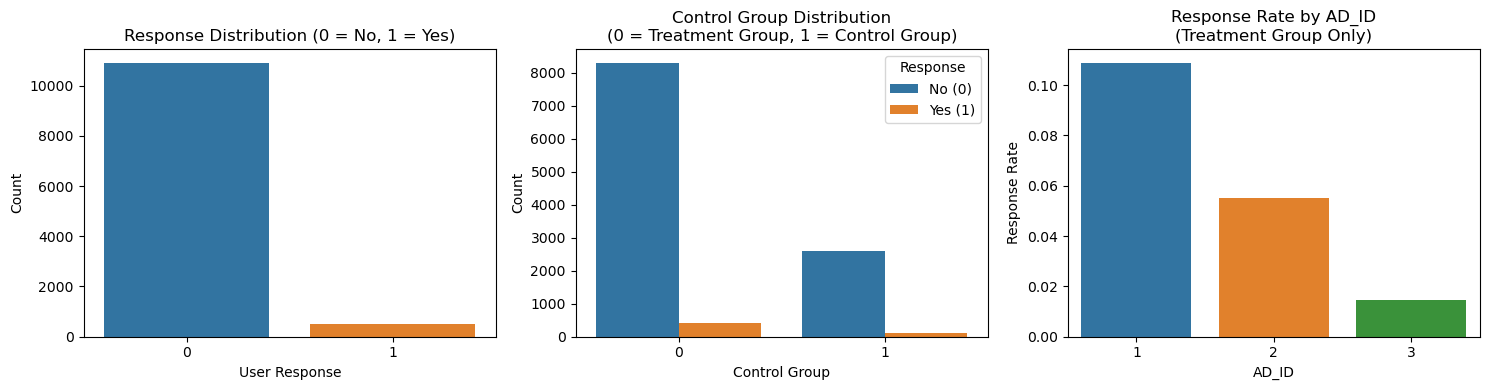

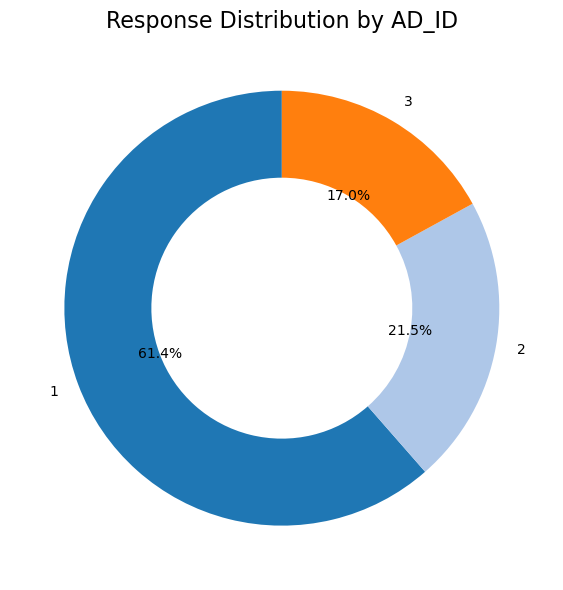

In [8]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Response Distribution
sns.countplot(data=df_viz, x="RESPONSE", hue='RESPONSE',
              palette=['#1f77b4', '#ff7f0e'], legend=False, ax=axes[0])
axes[0].set_title("Response Distribution (0 = No, 1 = Yes)")
axes[0].set_xlabel("User Response")
axes[0].set_ylabel("Count")


# Control vs Treatment Distribution
sns.countplot(data=df_viz, x="CONTROL", hue='RESPONSE',
              palette=['#1f77b4', '#ff7f0e'], ax=axes[1])

# Add labels and title
axes[1].set_title("Control Group Distribution\n(0 = Treatment Group, 1 = Control Group)")
axes[1].set_xlabel("Control Group")
axes[1].set_ylabel("Count")

# Add legend
axes[1].legend(title="Response", labels=["No (0)", "Yes (1)"])

# Response Rate by AD_ID (only treatment group)
ad_response_rate = df_viz[df_viz["CONTROL"] == 0].groupby("AD_ID")["RESPONSE"].mean().reset_index()
print(ad_response_rate)
sns.barplot(data=ad_response_rate, x="AD_ID", y="RESPONSE", hue="AD_ID",
            palette=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False, ax=axes[2])
axes[2].set_title("Response Rate by AD_ID\n(Treatment Group Only)")
axes[2].set_xlabel("AD_ID")
axes[2].set_ylabel("Response Rate")

plt.tight_layout()
plt.show()

# Response Distribution by AD ID
response_by_ad = df_viz.groupby('AD_ID')['RESPONSE'].sum()

# Plot donut chart
plt.figure(figsize=(6, 6))
colors = plt.cm.tab20.colors[:len(response_by_ad)]  # Generate unique colors
plt.pie(response_by_ad, labels=response_by_ad.index, autopct='%1.1f%%', startangle=90,
        colors=colors, wedgeprops=dict(width=0.4))

plt.gca().set_aspect('equal')
plt.title('Response Distribution by AD_ID', size=16)
plt.tight_layout()
plt.show()

##### Insights from the Plots

1. Class Imbalance in User Responses
    - The overwhelming majority of sessions resulted in no user response (RESPONSE = 0), while only a small portion led to a positive conversion (RESPONSE = 1).
2. Low Overall Conversion Rate:
	- Fewer users responded positively to marketing strategies.
	- This indicates that either the strategies were not compelling enough or the targeting wasn’t optimized.
3.	Control vs Treatment Group Distribution:
	- The treatment group (users who were shown ads) forms the majority, while the control group (not shown ads) is smaller.
4. Ad Effectiveness by AD_ID:
	- Among the treatment group:
	    - Ad 0 shows the highest response rate (~11%) and distribution (~61.4%), suggesting it is the most persuasive..
	    - Ad 1 performs moderately response rate (~6%) and distribution (~21.5%).
	    - Ad 2 has the lowest effectiveness (~1%) and distribution (~17%), indicating it may need to be redesigned or retargeted.
	- This indicates that not all ads are equally persuasive, and Ad 1 is the most effective.

CONTROL 0 vs 1:
- CONTROL 1: This user was part of the control group – selected for a marketing strategy experiment but not shown one. Their behavior represents what would happen without the strategy's influence.
- CONTROL 0: This user was in the treatment group – they were shown a specific ad (AD_ID 1, 2, or 3)

### 3.2 Time-Based Response Analysis<a id='32'></a>

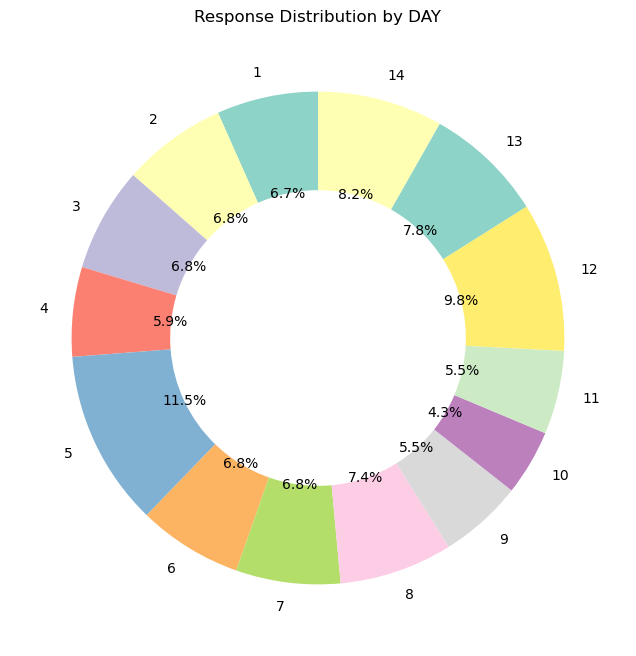

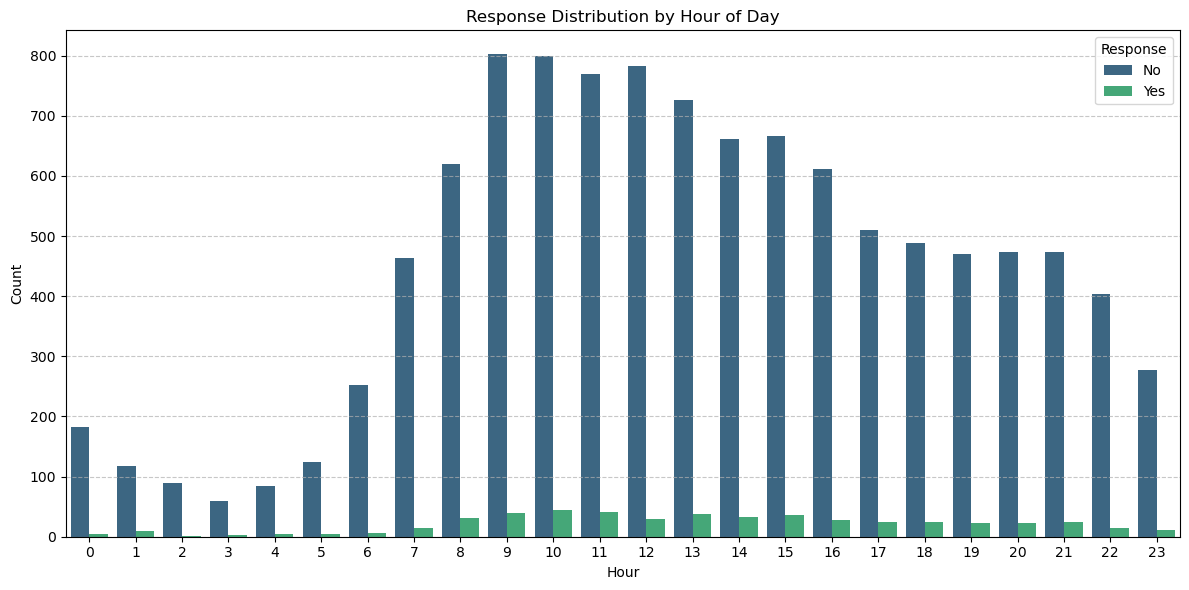

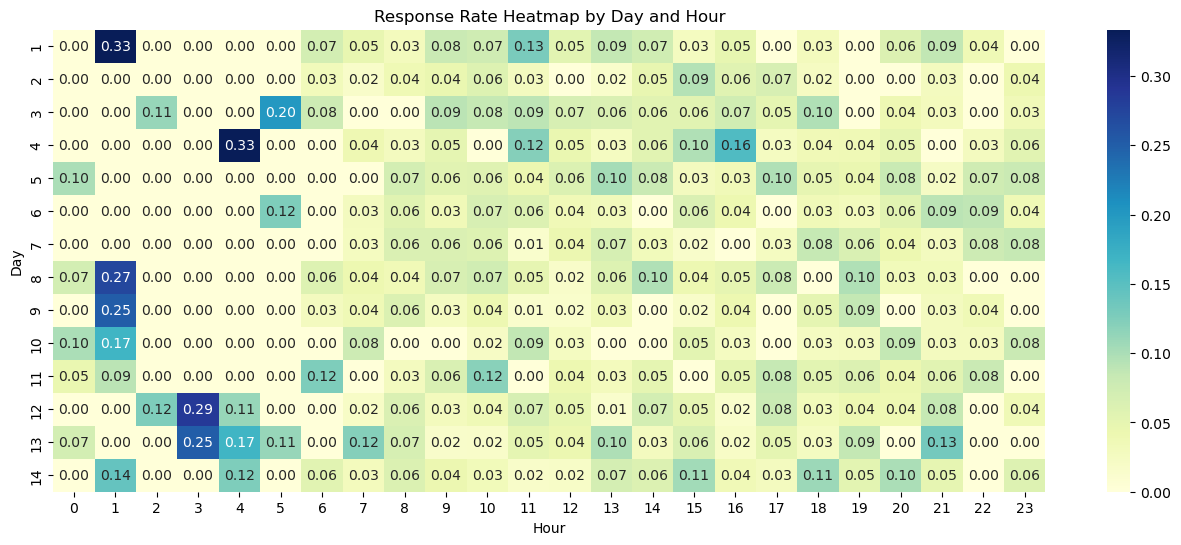

In [9]:
# Response Distribution by DAY
response_by_day = df_viz.groupby('DAY')['RESPONSE'].sum()
plt.figure(figsize=(8, 8))
plt.pie(response_by_day, labels=response_by_day.index, autopct='%1.1f%%', startangle=90,
        wedgeprops=dict(width=0.4), colors=sns.color_palette('Set3'))
plt.gca().set_aspect('equal')
plt.title('Response Distribution by DAY')
plt.show()

# Response Distribution by Hour of Day
plt.figure(figsize=(12, 6))
sns.countplot(data=df_viz, x='HOUR', hue='RESPONSE', palette='viridis')
plt.title('Response Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title='Response', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Heatmap of Response Rate by Day and Hour
response_matrix = df_viz.pivot_table(values='RESPONSE', index='DAY', columns='HOUR')
plt.figure(figsize=(16, 6))
sns.heatmap(response_matrix, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Response Rate Heatmap by Day and Hour')
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()


##### Insights from the plots

- Responses by Day:
    - Certain days, such as Day 5 and Day 12, show a notably higher share of user responses, suggesting stronger engagement or greater campaign effectiveness on those days.

- Responses by Hour:
	- User activity (session count) is highest between 9 AM to 3 PM, indicating peak browsing periods. This suggests that late morning to early afternoon may be the most effective window for marketing strategies, where both visibility and user responsiveness are elevated.

- Heatmap – Response Rate by Day and Hour:
	- The heatmap reveals distinct time windows with elevated response rates, particularly:
		- Day 1 at 1 AM and Day 4 at 4 AM – exceptionally high engagement (33%).
		- Day 8 at 1 AM, Day 9 at 1 AM, and Day 12 and 13 at 3 AM to 4 AM also show notable peaks (25–29%).
	- These spikes suggest that certain days and early-morning hours are strategically optimal for deploying marketing strategies.

### 3.3. Feature Distributions and Correlation Analysis for AD Response Modeling<a id='33'></a>

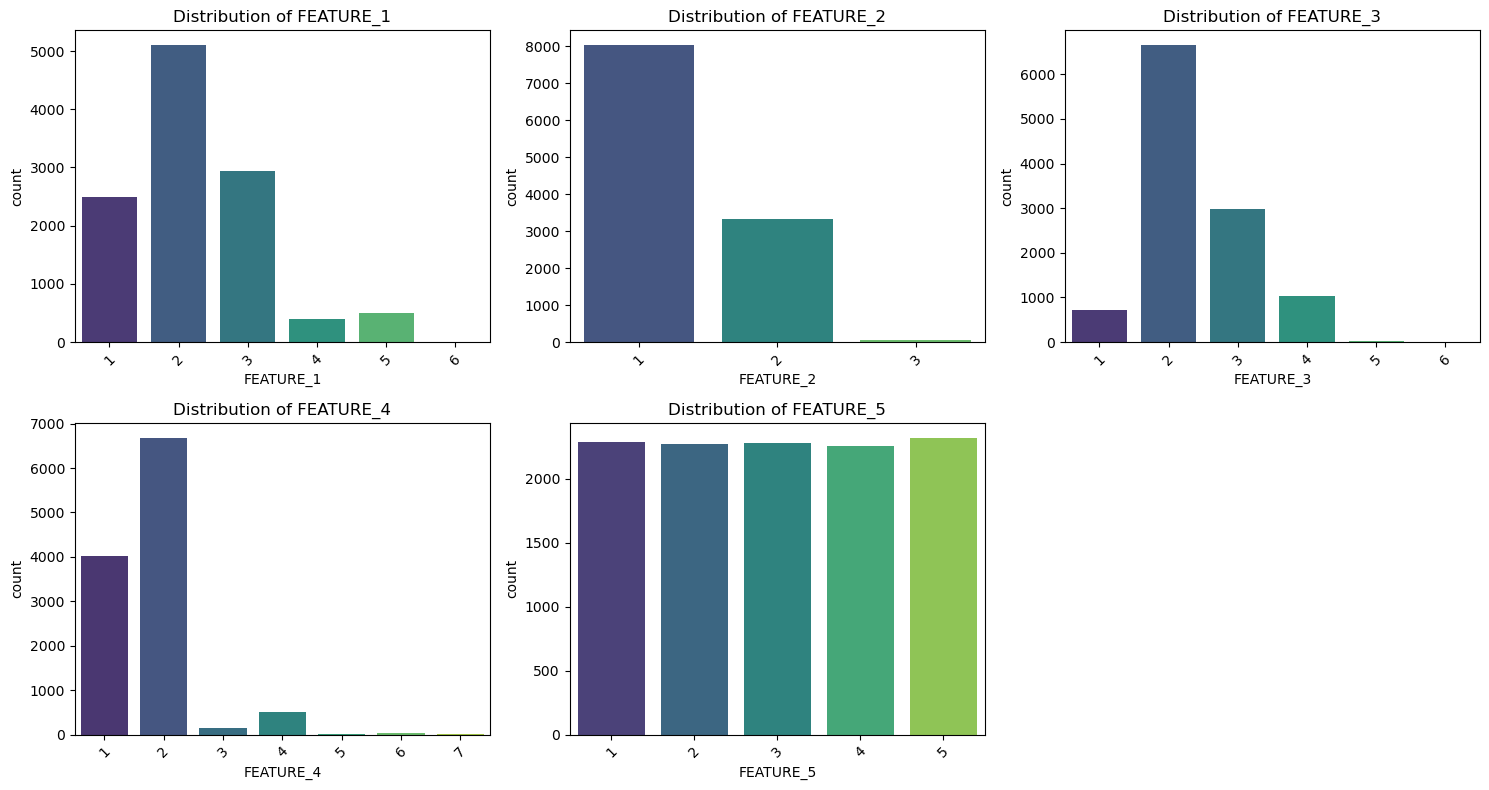

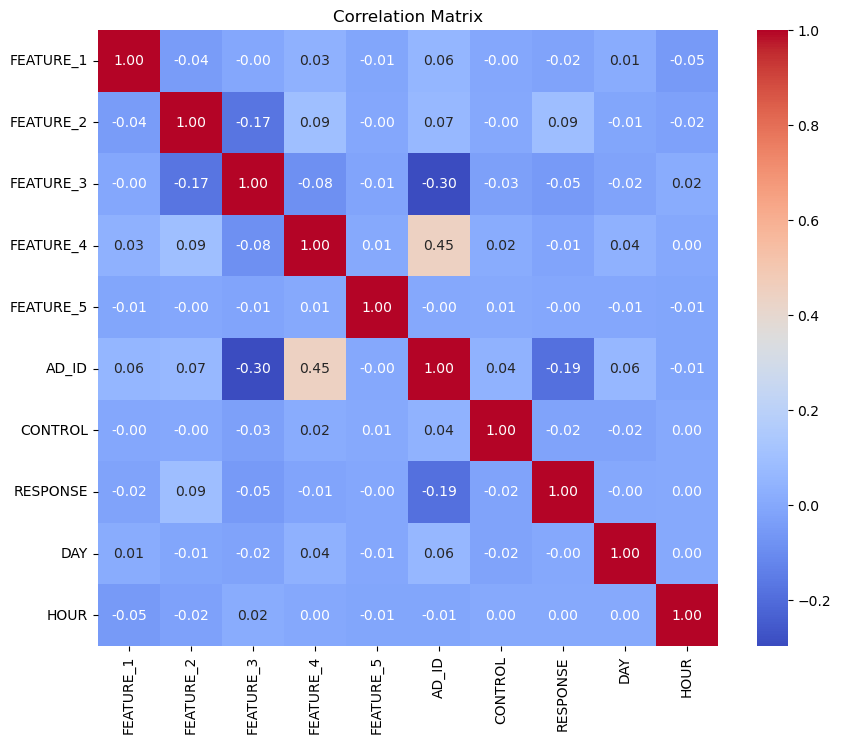

In [10]:
# Select only FEATURE columns
feature_cols = [col for col in df_viz.columns if col.startswith("FEATURE_")]

# Plot the distribution of each feature
fig, axes = plt.subplots(nrows=len(feature_cols)//3 + 1, ncols=3, figsize=(15, 4 * (len(feature_cols)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.countplot(data=df_viz, x=col, ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Compute correlation matrix (convert features to numeric if needed)
df_encoded = pd.get_dummies(df_viz[feature_cols], drop_first=True)
correlation_matrix = df_encoded.corr()

#Correlation matrix (only for numeric columns)
# Select only numeric columns
numeric_df = df_viz.select_dtypes(include=[np.number])

# Select numeric columns and drop 'COMBINED_FEATURE'
numeric_df = df_viz.select_dtypes(include=[np.number]).drop(columns=['COMBINED_FEATURE'], errors='ignore')

# Check if there are numeric columns
if not numeric_df.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("No numeric columns available for correlation matrix.")

##### Insights from the plots

- Distribution of Categorical Features (FEATURE_1 to FEATURE_5)
    - FEATURE_1 and FEATURE_3 show right-skewed distributions with few dominant categories.
    - EATURE_2 is heavily concentrated on category 1, suggesting low variability.
    - FEATURE_4 also has a dominant category, indicating imbalance in representation.
    - FEATURE_5 is uniformly distributed, which may make it less useful for predictive modeling as it does not differentiate user behavior.

- Correlation Matrix of All Variables Including AD_ID and RESPONSE
    - RESPONSE (Target Variable):
	    - Shows very weak correlations with all individual features (values close to 0), suggesting that no single feature strongly drives user response in isolation.
	    - This indicates that interactions or non-linear combinations of features may be more useful for predicting responses, supporting the use of tree-based models or ensemble methods.
	- AD_ID:
	    - Displays a moderate positive correlation with FEATURE_4 (0.45), suggesting that certain ads may be more frequently assigned to specific user segments characterized by FEATURE_4.
	    - Also shows a negative correlation with FEATURE_3 (-0.30), hinting at potential targeting or audience exclusion based on this feature.
	- Control Variables:
	    - CONTROL is largely uncorrelated with most other variables, confirming that users in the control group were randomly assigned, which is desirable in experimental design.
    - Feature Interdependencies:
	    - Most features are not strongly correlated with each other, indicating low multicollinearity, which is favorable for many models including logistic regression.
	    - Minor positive relationships exist (e.g., between FEATURE_2 and FEATURE_4), but none are concerning for model assumptions.
	- DAY and HOUR:
	    - Show negligible correlation with RESPONSE, which doesn’t mean they are unimportant — their effect could be non-linear or interaction-based (e.g., response patterns depending on combinations of DAY + HOUR).

### 3.4. Correlation Funnel<a id='34'></a>

In [11]:
# Step 1: Binarize the dataset
binarized_df = df_viz.binarize(thresh_infreq=0.0)
print(binarized_df)
# Step 2: Correlate with the target
correlation_df = binarized_df.correlate('RESPONSE__1')

# Step 3: Add label column manually for display
#correlation_df['label'] = correlation_df['bin'].astype(str)

# Step 4: Plot funnel and store the figure
fig = correlation_df.plot_correlation_funnel(
    engine='plotly',
    height=600,
    width=700
)

# Step 5: Add vertical red dotted line at x=0
fig.add_shape(
    type='line',
    x0=0,
    y0=0,
    x1=0,
    y1=1,
    xref='x',
    yref='paper',
    line=dict(color='red', width=2, dash='dot')
)

# Step 6: Add labels to each point
fig.update_traces(
    #text=correlation_df['label'],
    textposition='top right',
    mode='markers+text',
   
)

# Show the updated plot
fig.show()

       DAY__1.0_4.0  DAY__4.0_7.0  DAY__7.0_11.0  DAY__11.0_14.0  \
0                 1             0              0               0   
1                 1             0              0               0   
2                 1             0              0               0   
3                 1             0              0               0   
4                 1             0              0               0   
...             ...           ...            ...             ...   
14196             0             0              0               1   
14197             0             0              0               1   
14199             0             0              0               1   
14200             0             0              0               1   
14201             0             0              0               1   

       HOUR__0.0_9.0  HOUR__9.0_13.0  HOUR__13.0_17.0  HOUR__17.0_23.0  \
0                  1               0                0                0   
1                  0               

- Features with greater correlation with responding to the marketing campaign:
    - For feature 3, category 1 is more likely to give a positive response.
    - For AD ID, ad strategy 2 is more likely to give a positive response.
    - For feature 4, category 1 is more likely to give a positive response.
    - The others have weak correlation.

### 3.5. Advanced Heatmap with Hierarchical Clustering<a id='35'></a>

<Figure size 1200x1000 with 0 Axes>

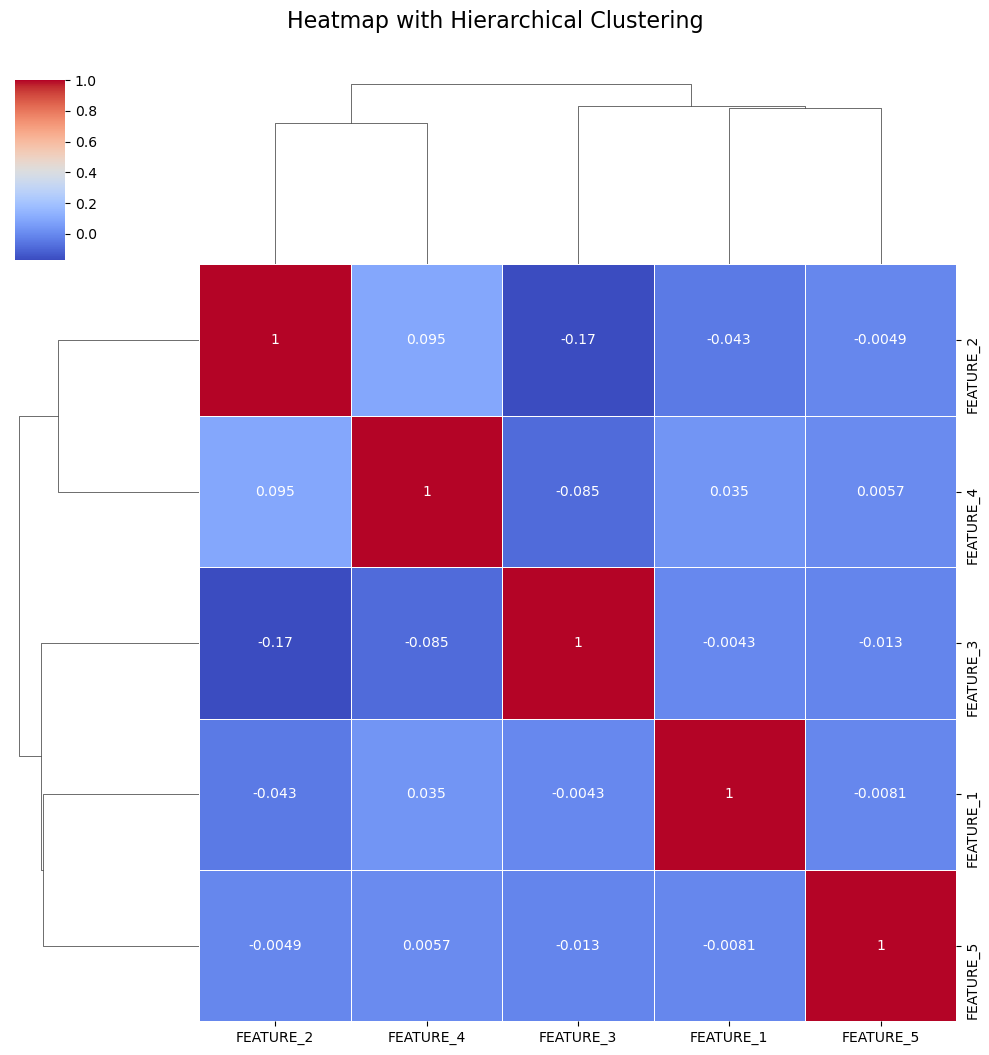

In [12]:
# Plot hierarchical clustered heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, method='ward')
plt.suptitle('Heatmap with Hierarchical Clustering', size=16, y=1.05)
plt.show()

##### Insights from Hierarchical Heatmap 
- Low Correlation Across Features
    - Most features exhibit very low correlation (absolute values close to 0), confirming that the variables are largely independent.
	- This is ideal for many machine learning models, especially ensemble methods, as it helps prevent multicollinearity.
- No Strong Feature Clusters
	- The dendrogram shows no clear dominant clusters.
	- The features do not group into tight correlated clusters, which supports the idea that each contributes uniquely to model learning.
- Mild Associations
	- A few mild associations are visible:
	    - FEATURE_2 and FEATURE_4 show a small positive correlation (~0.095).
	    - FEATURE_2 and FEATURE_3 have a slightly negative relationship (-0.17), but not strong enough to indicate redundancy.
- Implication for Modeling
	- Since features are relatively uncorrelated, dimensionality reduction (e.g., PCA) may not provide large gains.
	- Models like Random Forest, XGBoost, or Logistic Regression can effectively benefit from this feature diversity without the risk of overfitting due to collinearity.

### 3.6. Control, Time vs Response Visualization<a id='36'></a>

<Figure size 1000x600 with 0 Axes>

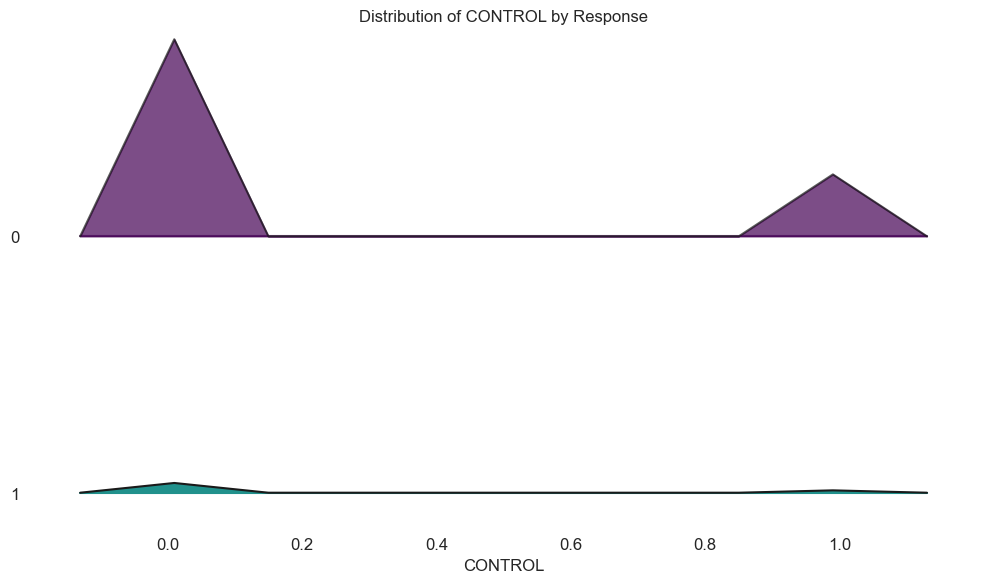

<Figure size 1000x600 with 0 Axes>

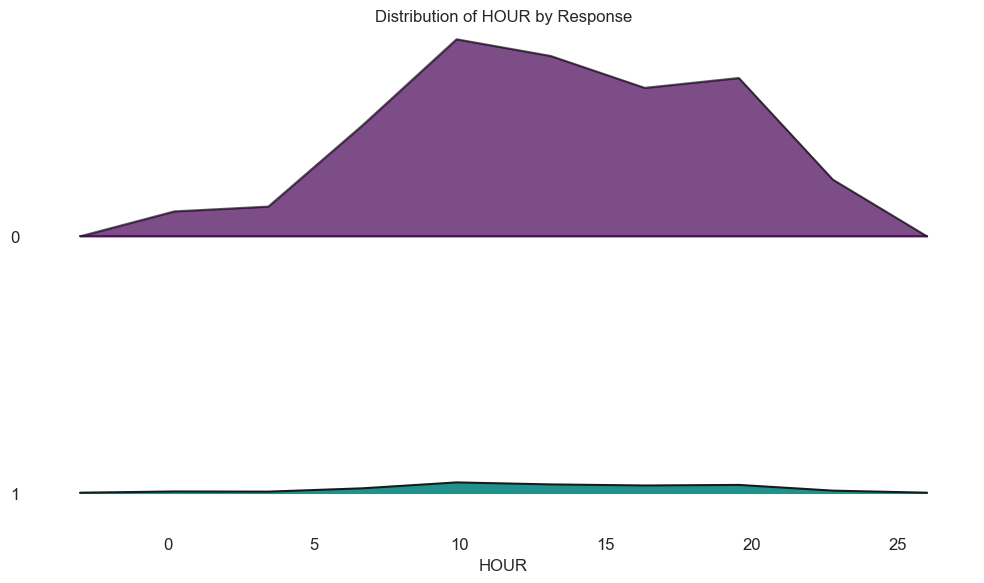

<Figure size 1000x600 with 0 Axes>

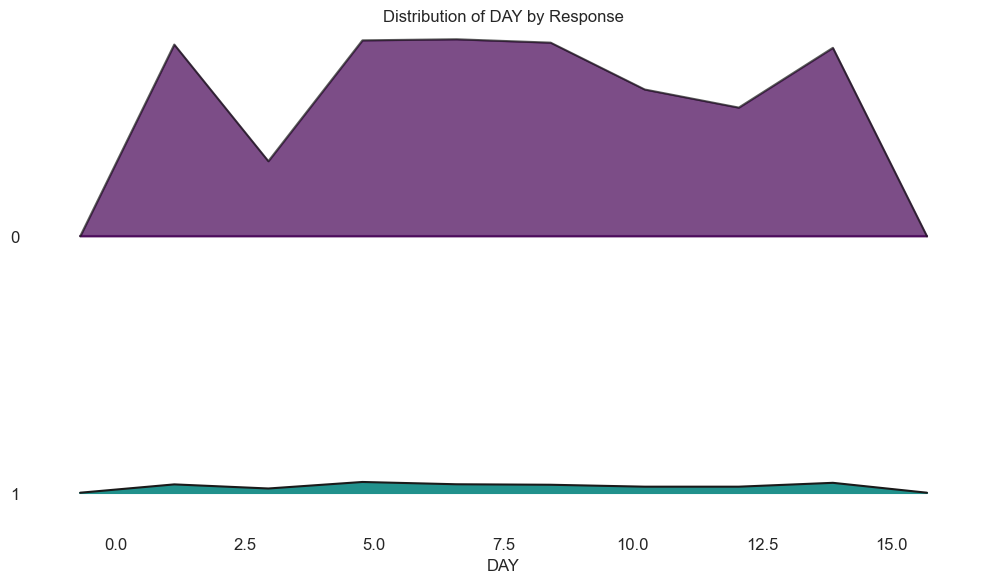

In [13]:
# Set seaborn style
sns.set(style="whitegrid")

# List of features to plot
plot_features = ['CONTROL','HOUR', 'DAY']

# Loop through each feature to create ridgeline plots
for feature in plot_features:
    plt.figure(figsize=(10, 6))
    joyplot(
        data=df_viz[[feature, 'RESPONSE']],
        by='RESPONSE',
        column=feature,
        figsize=(10, 6),
        colormap=plt.cm.viridis,
        fade=True,
        kind='counts'
    )
    plt.title(f'Distribution of {feature} by Response')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()


##### Insights from the Plots
- CONTROL by Response
    - Almost all responses occurred in the treatment group (CONTROL = 0).
	- The control group (CONTROL = 1) had negligible response activity.
	- Strong indication that ad exposure drives user action, validating experimental design.

- HOUR by Response
	- Non-responses peak between 10:00 and 19:00.
	- Responses are more consistent throughout the day with minor increases mid-day.
	- Suggests optimal ad timing may be during active hours, but time-of-day has moderate predictive value.

- DAY by Response
	- Responses are evenly spread across the 14-day period.
	- No noticeable trends or peaks by day.
	- Indicates the day variable alone has low influence on response behavior.


## 4. Modeling

### 4.1. Feature Engineering<a id='41'></a>

In [14]:
# Check unique values of RESPONSE and CONTROL
unique_response = df_cleaned['RESPONSE'].unique()
unique_control = df_cleaned['CONTROL'].unique()

print(unique_response)
print(unique_control)

# Convert RESPONSE and CONTROL to categorical if not already
df_cleaned['RESPONSE'] = df_cleaned['RESPONSE'].astype('category')

# Encode target variable (RESPONSE) as numeric for modeling
df_cleaned['RESPONSE'] = df_cleaned['RESPONSE'].cat.codes  # 0 remains 0, 1 remains 1

# Split features and target
X = df_cleaned.drop(columns='RESPONSE')
y = df_cleaned['RESPONSE']

# Show info after conversion and splitting
{
    "Data Types After Conversion": X.dtypes.to_dict(),
    "Target Variable Encoded": y.unique().tolist(),
    "Shape of X": X.shape,
    "Shape of y": y.shape
}

[0, 1]
Categories (2, int64): [0, 1]
[0, 1]
Categories (2, int64): [0, 1]


{'Data Types After Conversion': {'FEATURE_1': CategoricalDtype(categories=[1, 2, 3, 4, 5, 6], ordered=False, categories_dtype=int64),
  'FEATURE_2': CategoricalDtype(categories=[1, 2, 3], ordered=False, categories_dtype=int64),
  'FEATURE_3': CategoricalDtype(categories=[1, 2, 3, 4, 5, 6], ordered=False, categories_dtype=int64),
  'FEATURE_4': CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7], ordered=False, categories_dtype=int64),
  'FEATURE_5': CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=False, categories_dtype=int64),
  'AD_ID': CategoricalDtype(categories=[1, 2, 3], ordered=False, categories_dtype=int64),
  'CONTROL': CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64),
  'DAY': dtype('int64'),
  'HOUR': dtype('int64')},
 'Target Variable Encoded': [0, 1],
 'Shape of X': (11423, 9),
 'Shape of y': (11423,)}

In [15]:
# Identify numerical and categorical features
numerical_features = []
categorical_features = [col for col in X.columns if X[col].nunique() < 100 and col != 'time']
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 4.2. Model Building and Evaluation: Advanced Analysis (Random Forest)<a id='42'></a>

Random Forest Accuracy: 0.95

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2183
           1       0.42      0.16      0.23       102

    accuracy                           0.95      2285
   macro avg       0.69      0.57      0.60      2285
weighted avg       0.94      0.95      0.94      2285



<Figure size 600x400 with 0 Axes>

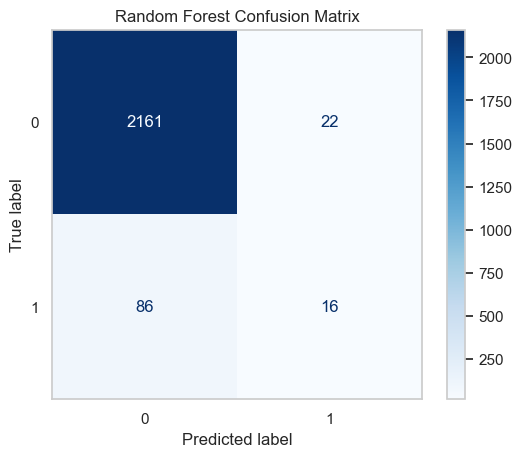

In [17]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train, y_train)
base_pred = base_rf.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, base_pred):.2f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, base_pred))

# Confusion matrix
cm = confusion_matrix(y_test, base_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_rf.classes_)

# Plot
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()

##### Random Forest Model Summary
- Overall Accuracy: 95% on the test set.
- Class 0 (Non-Response):
	- Precision: 0.96
	- Recall: 0.99
	- F1 Score: 0.98
	- Very strong performance on the majority class.
- Class 1 (Response):
	- Precision: 0.42
	- Recall: 0.16
	- F1 Score: 0.23
- Struggles to correctly identify users who respond to marketing.

Insights
- The model is highly skewed toward predicting non-responses, likely due to class imbalance.
- Despite high accuracy, precision/recall for the positive class is low, which means many potential conversions may be missed.


### 4.3. Prediction Models: Logistic Regression, Random Forest, and XGBoost Comparisons<a id='43'></a>

Logistic Regression Accuracy: 0.96
Random Forest Accuracy: 0.95
XGBoost Accuracy: 0.95

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2183
           1       0.50      0.01      0.02       102

    accuracy                           0.96      2285
   macro avg       0.73      0.50      0.50      2285
weighted avg       0.94      0.96      0.93      2285


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2183
           1       0.42      0.16      0.23       102

    accuracy                           0.95      2285
   macro avg       0.69      0.57      0.60      2285
weighted avg       0.94      0.95      0.94      2285


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2183
           1       0.29      0.16   

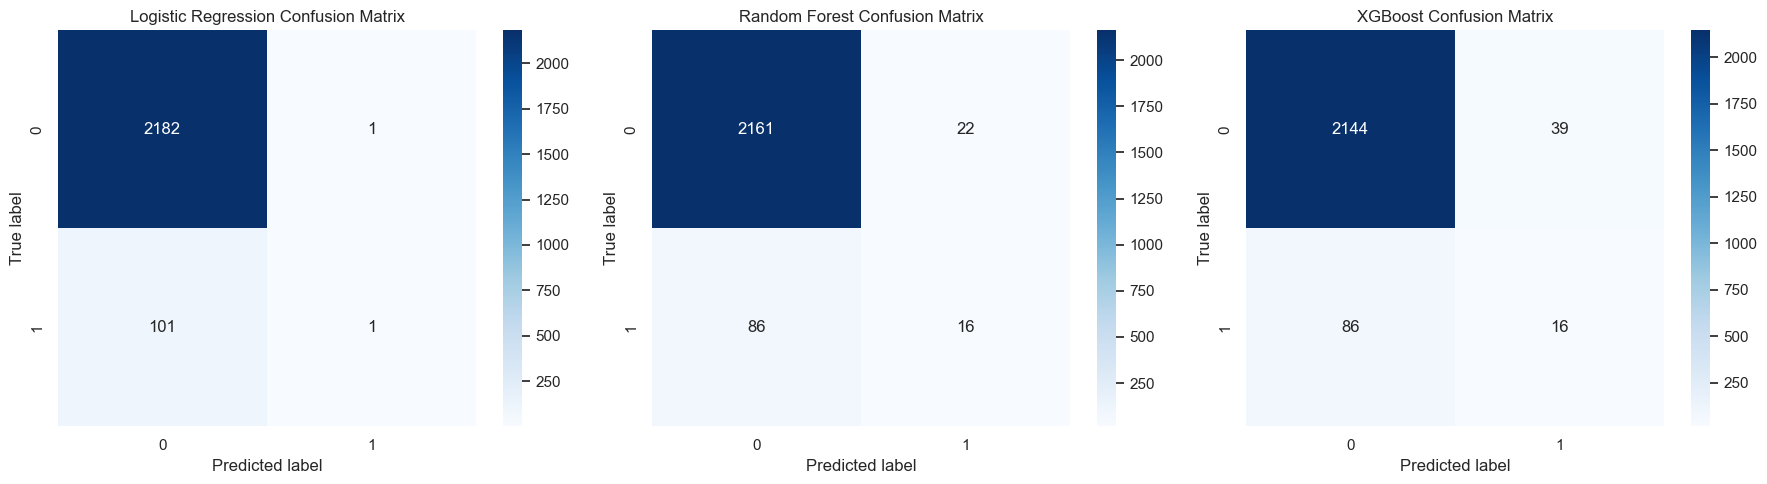

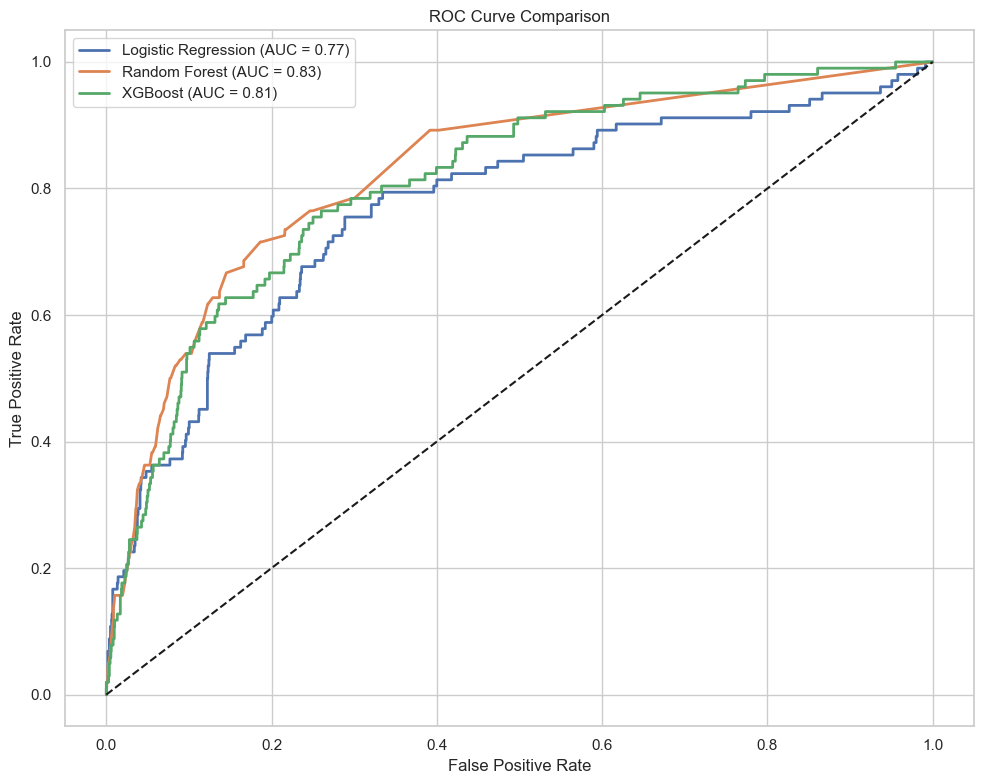

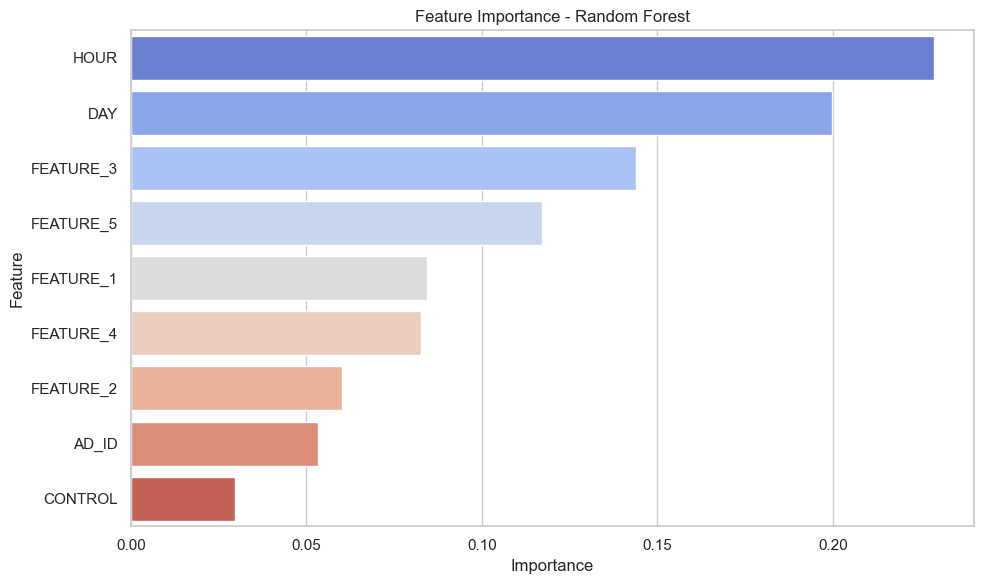

In [18]:
# Initialize models
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models
logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predictions
logistic_pred = logistic_model.predict(X_test)
random_forest_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Accuracy
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, logistic_pred):.2f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, random_forest_pred):.2f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.2f}")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logistic_pred))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, random_forest_pred))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

# Confusion Matrices
# Create figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrices
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
predictions = [logistic_pred, random_forest_pred, xgb_pred]

for ax, model, pred in zip(axes, models, predictions):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model} Confusion Matrix')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for model, y_prob, label in zip(
    [logistic_model, random_forest_model, xgb_model],
    [logistic_model.predict_proba(X_test)[:, 1],
     random_forest_model.predict_proba(X_test)[:, 1],
     xgb_model.predict_proba(X_test)[:, 1]],
    ['Logistic Regression', 'Random Forest', 'XGBoost']):

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
rf_importance = random_forest_model.feature_importances_

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

##### Models Comparison Summary
- Accuracy
	- Logistic Regression: 96%
	- Random Forest: 95%
	- XGBoost: 95%
	- All models perform well in overall accuracy, but accuracy alone is not sufficient due to class imbalance.

- Confusion Matrix Analysis
	- Logistic Regression has the best accuracy but worst recall for detecting positive cases.
	- Random Forest balances precision and recall better.
	- XGBoost matches Random Forest in recall but has lower precision.

- AUC Scores
	- Logistic Regression: 0.77
	- Random Forest: 0.83
	- XGBoost: 0.81
	- Random Forest and XGBoost outperform Logistic Regression in AUC, indicating stronger performance in distinguishing between classes.

Random Forest is the best-performing model for this marketing task because it offers the strongest balance between accuracy, recall, and AUC. Unlike Logistic Regression, which achieved high accuracy but failed to detect most positive responses, Random Forest identified significantly more true positives (16 vs. 1) while maintaining high overall accuracy. Its higher AUC (0.83) also indicates better ability to distinguish between responders and non-responders across thresholds, making it a more reliable choice when identifying conversions is critical.

### 4.4. SMOTE + Cross-Validation, Hyperparameter Tuning, Evaluation Analysis<a id='44'></a>

In [19]:
from scipy.stats import uniform, randint

# Step 1: Initialize models
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Step 2: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Cross-Validation Scores (on SMOTE data)
logistic_cv_scores = cross_val_score(logistic_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Logistic Regression CV Accuracy: {logistic_cv_scores.mean():.2f} ± {logistic_cv_scores.std():.2f}")

rf_cv_scores = cross_val_score(random_forest_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.2f} ± {rf_cv_scores.std():.2f}")

xgb_cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.2f} ± {xgb_cv_scores.std():.2f}")

# Step 4: Define hyperparameter grids
logistic_params = {
    'C': uniform(0.01, 10),
    'solver': ['liblinear', 'lbfgs']
}

rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': [5, 10, None],
    'min_samples_split': randint(2, 10)
}

xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3)
}

# Step 5: Perform RandomizedSearchCV
logistic_search = RandomizedSearchCV(logistic_model, logistic_params, cv=5, scoring='accuracy', random_state=42)
rf_search = RandomizedSearchCV(random_forest_model, rf_params, cv=5, scoring='accuracy', random_state=42)
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy', random_state=42)

logistic_search.fit(X_train_resampled, y_train_resampled)
rf_search.fit(X_train_resampled, y_train_resampled)
xgb_search.fit(X_train_resampled, y_train_resampled)

# Step 6: Report Best Parameters
print(f"Best Logistic Regression Parameters: {logistic_search.best_params_}")
print(f"Best Random Forest Parameters: {rf_search.best_params_}")
print(f"Best XGBoost Parameters: {xgb_search.best_params_}")

# Step 7: Final Evaluation on Original Test Set
logistic_best = logistic_search.best_estimator_
rf_best = rf_search.best_estimator_
xgb_best = xgb_search.best_estimator_

y_pred_logistic = logistic_best.predict(X_test)
y_pred_rf = rf_best.predict(X_test)
y_pred_xgb = xgb_best.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Accuracy Summary
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logistic):.2f}")
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")

Logistic Regression CV Accuracy: 0.72 ± 0.01
Random Forest CV Accuracy: 0.98 ± 0.02
XGBoost CV Accuracy: 0.97 ± 0.02
Best Logistic Regression Parameters: {'C': np.float64(0.017787658410143285), 'solver': 'lbfgs'}
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 171}
Best XGBoost Parameters: {'learning_rate': np.float64(0.189597545259111), 'max_depth': 9, 'n_estimators': 221, 'subsample': np.float64(0.7467983561008608)}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      2183
           1       0.11      0.75      0.19       102

    accuracy                           0.71      2285
   macro avg       0.54      0.73      0.50      2285
weighted avg       0.94      0.71      0.79      2285


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2183
           1     

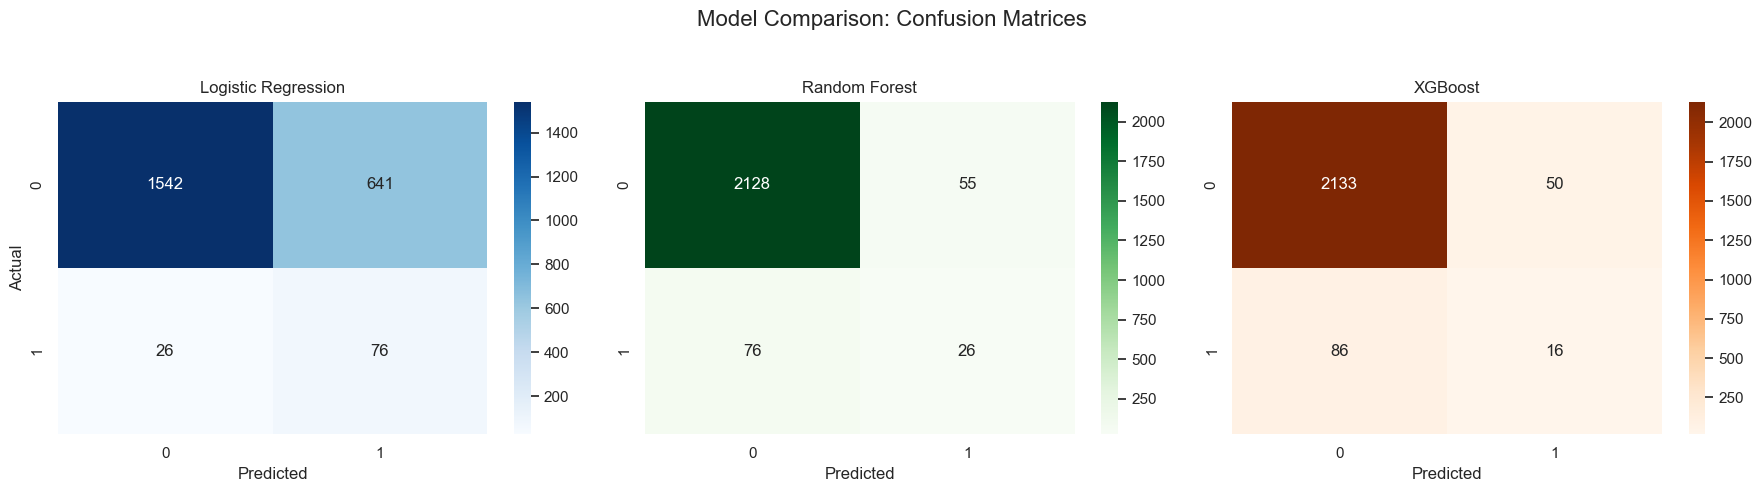

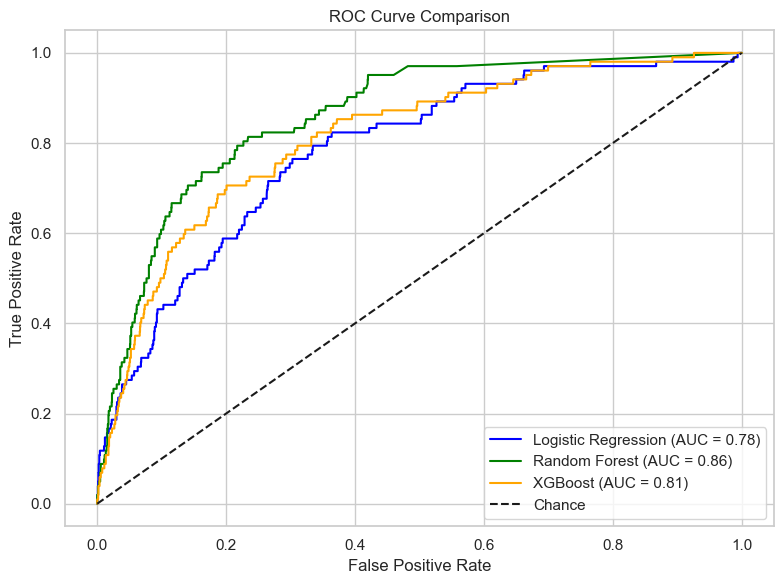

In [20]:
# --------------------- CONFUSION MATRIX COMPARISON ---------------------

# List of predictions from tuned models
model_preds = [y_pred_logistic, y_pred_rf, y_pred_xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
color_maps = ['Blues', 'Greens', 'Oranges']

# Subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (pred, name, cmap) in enumerate(zip(model_preds, model_names, color_maps)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual' if i == 0 else '')

plt.suptitle('Model Comparison: Confusion Matrices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --------------------- ROC CURVE COMPARISON ---------------------

# Probabilities from best models
model_probs = [
    ('Logistic Regression', logistic_best.predict_proba(X_test)[:, 1], 'blue'),
    ('Random Forest', rf_best.predict_proba(X_test)[:, 1], 'green'),
    ('XGBoost', xgb_best.predict_proba(X_test)[:, 1], 'orange')
]

plt.figure(figsize=(8, 6))

for label, probs, color in model_probs:
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=color)

# Diagonal baseline
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Models Comparison Insights
| Model               | Setting                         | Accuracy | Recall (Class 1) | AUC  | Key Insight                                             |
|--------------------|----------------------------------|----------|------------------|------|---------------------------------------------------------|
| Logistic Regression| Baseline                         | 0.96     | 0.01             | 0.77 | High accuracy, misses positives                         |
| Logistic Regression| SMOTE + Tuning                   | 0.71     | 0.75             | 0.78 | Best recall, good for targeting responders              |
| Random Forest      | Baseline                         | 0.95     | 0.16             | 0.83 | Balanced model, limited recall                          |
| Random Forest      | SMOTE + Tuning                   | 0.94     | 0.25             | 0.86 | Strong AUC, improved minority detection                 |
| XGBoost            | Baseline                         | 0.95     | 0.16             | 0.81 | Stable model, recall needs improvement                  |
| XGBoost            | SMOTE + Tuning                   | 0.94     | 0.16             | 0.84 | Slight recall boost, consistent performance             |

Based on the results, Random Forest with SMOTE and Hyperparameter Tuning performs the best overall when balancing accuracy (95%), recall (0.25), and AUC (0.86).

### 4.5. Learning Curve for Logistic Regression,Random Forest and XGBoost Models<a id='45'></a>

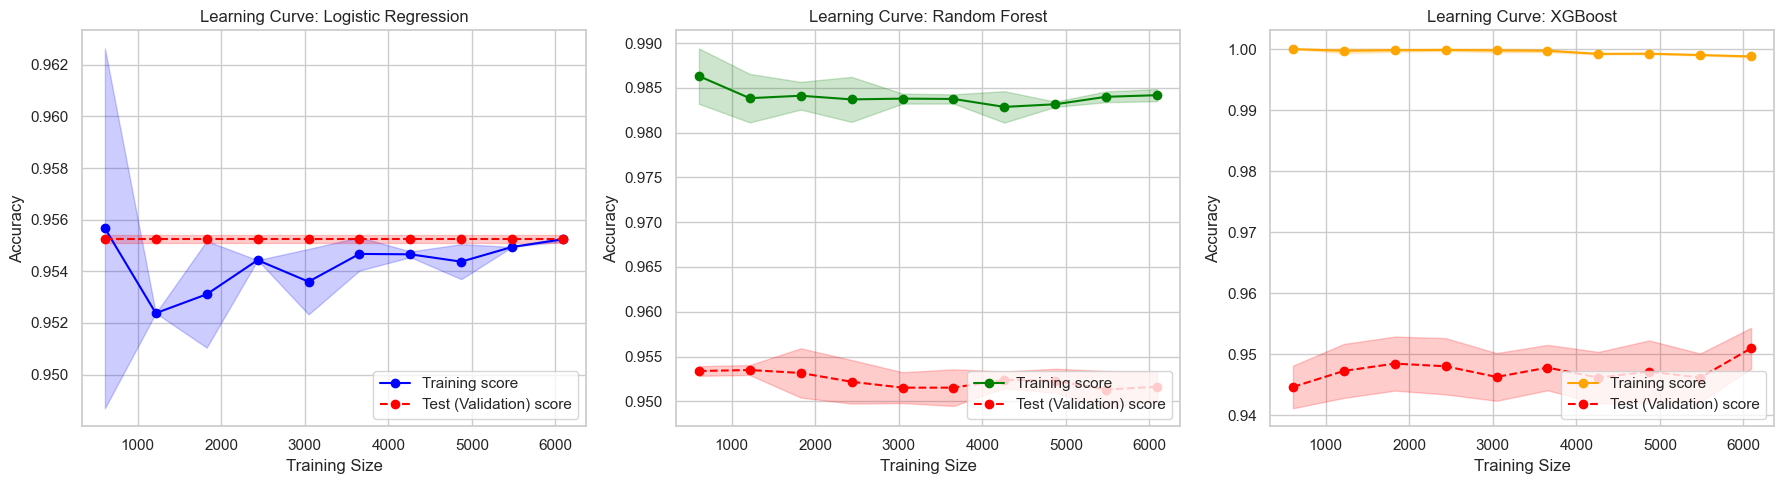

In [21]:
# List of models to evaluate
models = [
    ('Logistic Regression', logistic_best, 'blue'),
    ('Random Forest', rf_best, 'green'),
    ('XGBoost', xgb_best, 'orange')
]

# Plotting all learning curves
plt.figure(figsize=(18, 5))

for i, (name, model, color) in enumerate(models, 1):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=3, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, 3, i)
    plt.plot(train_sizes, train_mean, 'o-', color=color, label='Training score')
    plt.plot(train_sizes, test_mean, 'o--', color='red', label='Test (Validation) score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color=color, alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')  # <- Legend inside each subplot

plt.tight_layout()
plt.show()

##### Learning Curve Insights

| Model               | Gap       | Interpretation                                           |
|---------------------|-----------|----------------------------------------------------------|
| **Logistic Regression** | Small     | Stable and well-generalized.       |
| **Random Forest**       | Moderate  | Slightly overfitting observed.        |
| **XGBoost**             | Large     | Strong overfitting. Excellent fit on train, not on test. |

- Best Generalization: Logistic Regression – training and validation scores are consistent.
- Most Overfitting: XGBoost – large gap between training and validation accuracy.
- Random Forest: Slightly overfits, but validation accuracy is still strong and stable.

## 5. Conclusion

### 5.1. Key Findings and Insights<a id='51'></a>

- How We Analyzed the Data
	- We began by cleaning and exploring the dataset, which contained session-level data from an e-commerce platform. This included user activity, ad exposure (treatment vs. control), and a binary response outcome.
	- Exploratory Data Analysis (EDA) was conducted using distribution plots, heatmaps, ridge plots, and 3D visualizations to understand the patterns across features such as time of day, Ad ID, and control group assignments.
	- We applied machine learning models (Logistic Regression, Random Forest, XGBoost) to predict user responses, with techniques like SMOTE to address class imbalance and RandomizedSearchCV for hyperparameter tuning.

- Interesting Statistics for This Problem
	- Response Rate Imbalance: Estimate 5% of user sessions resulted in a positive response, highlighting a significant class imbalance challenge.
	- Model Recall Scores: Despite high accuracy (>94%) from tree-based models, recall for positive responses remained low, identifying an important weakness in detecting actual responders.
	- Hour-based Trends: Majority of user activity occurred between 10:00 AM and 6:00 PM, but engagement responses were more evenly distributed, suggesting opportunity outside peak hours.

- Data Organization and Visualization Approaches
	- Categorical features were visualized using bar and pie charts to highlight skewness and dominant categories.
	- Time features like HOUR and DAY were separated from the timestamp and plotted to identify engagement windows.
	- 3D scatter plots helped connect individual features with Ad IDs and response outcomes.
	- Correlation heatmaps helped confirm feature independence, supporting diverse feature use in modeling.


### 5.2. Summary<a id='52'></a>

The analysis reveals that while the dataset offers strong signals for modeling Ad effectiveness, class imbalance and skewed features present key challenges. Visual and statistical tools helped uncover the role of time, treatment exposure, and session features in user responses. From a modeling perspective, Random Forest and XGBoost offered reliable predictive power, though improving recall for actual responders remains an area for enhancement.

From a business and marketing strategy standpoint, this study report provides data-driven insights that can be directly translated into action:
- Ad Scheduling: Understanding when users are most active (and responsive) enables businesses to time their campaigns more effectively.
- Audience Segmentation: Patterns in session behavior and response rates help identify which user segments are more likely to convert, allowing for personalized targeting.
- A/B Testing Strategy: The control-treatment setup in the data allows businesses to validate the impact of their advertisements and refine messaging based on measurable engagement.
- Resource Allocation: By pinpointing the most effective Ad IDs and time slots, marketers can allocate budget more efficiently for maximum ROI.

In summary, this report equips decision-makers with evidence-based recommendations that enhance targeting accuracy, campaign timing, and conversion outcomes—ultimately contributing to more efficient and profitable marketing strategies.